In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 导入数据

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 数据清洗和转换

In [3]:
train_data = train.drop(['Ticket'], axis=1)

def transform_featrues(df):
    #标记缺失数据
    df.Age = df.Age.fillna(-0.5)
    df.Cabin = df.Cabin.fillna('N')
    df.Embarked = df.Embarked.fillna('N')
    df.Fare = df.Fare.fillna(-0.5)
    
    #提取仓位的第一个字母
    df.Cabin = df.Cabin.apply(lambda x: x[0]) 
    #拆分名字
    if 'Name' in df.columns:
        df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
        df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
        df.drop(columns='Name', inplace=True)
    #将年龄转换为整十的年龄段
    df.Age = df.Age//10 * 10
    return df

train_data = transform_featrues(train_data)
test = transform_featrues(test)

## 数据基本情况

* 可以看出，高等级船票的乘客，生还几率要高于低等级船票的乘客。所有女性的生还率都要高于男性，即便是3等船票的女性，生还率也高于1等船票的男性。
* 当以年龄来划分时，依旧是女性的生还率更高，但是10到20岁的男孩生还几率明显高于其他年龄段的男性。
* 可见在泰坦尼克号上，男性乘客们以生命为代价，把生存的机会留给了女性和孩子。让女人和孩子先走，得到了真正的执行。

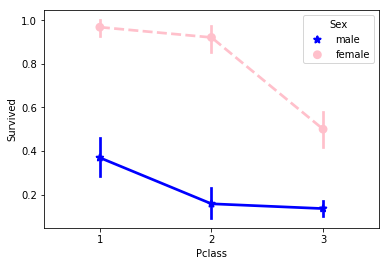

In [4]:
sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=train,
             palette={'male':'blue', 'female':'pink'},
             markers=['*', 'o'], linestyles=['-', '--'])

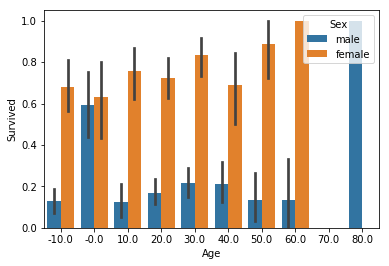

In [5]:
sns.barplot(x=train_data.Age//10 * 10, y="Survived", hue="Sex", data=train_data)

## 使用随机森林算法预测乘客的生还情况

* 用随机森林来预测乘客的生还率，在交叉验证集上，预测正确率为0.81，在kaggle的测试集上正确率为0.73分。
* 从模型输出的feature_importances可以看出，对于是否生还，影响最重要的是性别和票价（可以代表生活阶级）。

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [7]:
#标准化标签值（normalize labels）
from sklearn import preprocessing

features = ['Fare', 'Cabin', 'Age', 'Sex', 'Embarked', 'Lname', 'NamePrefix']
df_combined = pd.concat([train_data[features], test[features]])
for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(df_combined[feature])
    train_data[feature] = le.transform(train_data[feature])
    test[feature] = le.transform(test[feature])

#分离特征值(feature)和标签（label)
X_all = train_data.drop(['Survived', 'PassengerId'], axis=1)
y_all = train_data['Survived']

In [8]:
#使用随机森林算法预测乘客是否生还，用交叉验证来评估算法的表现
rf = RandomForestClassifier()
cross_val_score(rf, X_all, y_all, ).mean()

0.8103254769921436

In [9]:
#按在模型中的重要性排序所有特征
rf.fit(X_all, y_all)
importances = pd.DataFrame({'feature': X_all.columns, 'importance': rf.feature_importances_})
importances.sort_values('importance', ascending=False)

,feature,importance
1,Sex,0.207877
5,Fare,0.187234
8,Lname,0.185477
9,NamePrefix,0.107332
2,Age,0.084858
0,Pclass,0.069682
6,Cabin,0.063762
3,SibSp,0.042126
7,Embarked,0.029971
4,Parch,0.021680


## 导出预测结果

In [10]:
#导出预测结果，用于上传kaggle
result = pd.DataFrame({'PassengerId': test.PassengerId,
              'Survived': rf.predict(test[X_all.columns])})
result.to_csv('result.csv',index=False)